### The German Traffic Sign Benchmark

Student Name 1: Panagiotis Michalopoulos

Student Name 2: Filip Finfando

Download full data set from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

In [1]:
# use those numbers to change range in the next cell
! wc -l ./data/bin_labels_sorted.txt
! grep "00600.ppm" -B 5 -A 5 -m 1 ./data/bin_labels_sorted.txt --line-number

147540 ./data/bin_labels_sorted.txt
97022-00599.ppm;900;374;926;405;0
97023-00599.ppm;924;345;952;371;0
97024-00599.ppm;92;297;210;423;0
97025-00599.ppm;95;128;528;600;0
97026-00599.ppm;992;233;1013;255;0
97027:00600.ppm;0;0;154;157;0
97028-00600.ppm;0;0;408;353;0
97029-00600.ppm;0;0;528;563;0
97030-00600.ppm;0;272;288;600;0
97031-00600.ppm;0;321;236;531;0
97032-00600.ppm;0;414;143;549;0


In [2]:
number_of_samples = 147540
split_at = 97026
train_samples = 87000

In [3]:
import numpy as np
import cv2

IMG_HEIGHT = 600
#SIGN_SIZE = (224, 224)
SIGN_SIZE = (32, 32)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt('./data/bin_labels_sorted.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [4]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('../FullIJCNN2013', range(0,600), range(0,split_at))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('../FullIJCNN2013', range(600,900), range(split_at,number_of_samples))

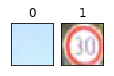

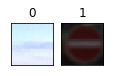

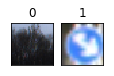

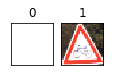

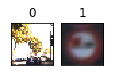

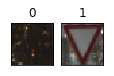

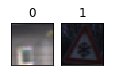

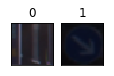

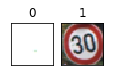

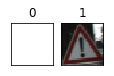

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)

for r in range(5000,5010):
    fig = plt.figure(figsize=(8,8))
    for i in range(num_classes):
        ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
        ax.set_title(class_names[i])
        indices = np.where(np.isin(train_labels, class_names[i]))[0]
        plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
    plt.show()

In [6]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)

## Balance Dataset

[[    0     1]
 [96174   852]]


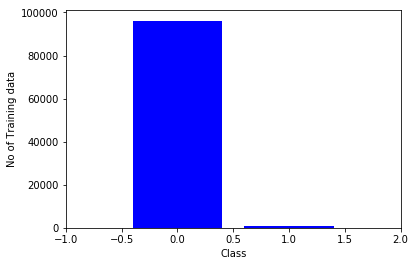

In [9]:
# Checking for class bias before data augmentation 

unique_elements, counts_elements = np.unique(np.array(train_labels).astype('int32'), return_counts = True)
print(np.asarray((unique_elements, counts_elements)))

plt.bar( np.arange( 2 ), counts_elements, align='center',color='blue' )
plt.xlabel('Class')
plt.ylabel('No of Training data')
plt.xlim([-1, 2])

plt.show()

In [10]:
from skimage.transform import rotate
from skimage.transform import warp
from skimage.transform import ProjectiveTransform

def rotate_image(image, max_angle =15):
    rotate_out = rotate(image, np.random.uniform(-max_angle, max_angle), mode='edge')
    return rotate_out

def translate_image(image, max_trans = 5, height=32, width=32):
    translate_x = max_trans*np.random.uniform() - max_trans/2
    translate_y = max_trans*np.random.uniform() - max_trans/2
    translation_mat = np.float32([[1,0,translate_x],[0,1,translate_y]])
    trans = cv2.warpAffine(image, translation_mat, (height,width))
    return trans
    
def projection_transform(image, max_warp=0.8, height=32, width=32):
    #Warp Location
    d = height * 0.3 * np.random.uniform(0,max_warp)
    
    #Warp co-ordinates
    tl_top = np.random.uniform(-d, d)     # Top left corner, top margin
    tl_left = np.random.uniform(-d, d)    # Top left corner, left margin
    bl_bottom = np.random.uniform(-d, d)  # Bottom left corner, bottom margin
    bl_left = np.random.uniform(-d, d)    # Bottom left corner, left margin
    tr_top = np.random.uniform(-d, d)     # Top right corner, top margin
    tr_right = np.random.uniform(-d, d)   # Top right corner, right margin
    br_bottom = np.random.uniform(-d, d)  # Bottom right corner, bottom margin
    br_right = np.random.uniform(-d, d)   # Bottom right corner, right margin
        
    ##Apply Projection
    transform = ProjectiveTransform()
    transform.estimate(np.array((
                (tl_left, tl_top),
                (bl_left, height - bl_bottom),
                (height - br_right, height - br_bottom),
                (height - tr_right, tr_top)
            )), np.array((
                (0, 0),
                (0, height),
                (height, height),
                (height, 0)
            )))
    output_image = warp(image, transform, output_shape=(height, width), order = 1, mode = 'edge')
    return output_image
    

def transform_image(image, max_angle=15, max_trans =5 ,max_warp=0.8):
    ## Simple pipline to take an input image and apply a serise of simple
    ## Distortions to augment the training data set
    ## (note: this function will rescale pixel values between 0-1)
    ##
    height, width, channels = image.shape
    #Rotate Image
    rotated_image = rotate_image(image, max_angle)
    #Translate Image
    translated_image = translate_image(rotated_image, max_trans, height, width)
    #Project Image
    output_image = projection_transform(translated_image, max_warp, height, width)
    return (output_image*255.0).astype(np.uint8)

    
def augment_and_balance_data(X_train, y_train, no_examples_per_class):
    
    n_examples = no_examples_per_class
    #Get paramters of data
    classes, class_indices, class_counts  = np.unique(y_train, return_index=True, return_counts=True)
    n_classes = len(class_counts)
    #print(n_classes)
    height, width, channels = X_train[0].shape
    
    
    #Create new data and labels for the balanced augmented data
    X_balance = np.empty([0, X_train.shape[1], X_train.shape[2], X_train.shape[3]], dtype = np.float32)
    y_balance = np.empty([0], dtype = np.int32)
    

    for c, count in zip(range(n_classes), class_counts):
        ##Copy over the current data for the given class
        X_orig = X_train[y_train == c]
        #print(X_orig.shape)
        y_orig = y_train[y_train == c]
        #print(y_orig.shape)
        ##Add original data to the new dataset
        X_balance = np.append(X_balance, X_orig, axis=0)
        print(c,count)
        temp_X = np.empty([n_examples-count, X_train.shape[1], X_train.shape[2], X_train.shape[3]], dtype = np.float32)
        #print(n_examples-count)
        for i in range(n_examples - count):
            #print(i%count)
            temp_X[i,:,:,:] = transform_image(X_orig[i%count]).reshape((1, height, width, channels))
            
            
        X_balance = np.append(X_balance,temp_X, axis=0)
        n_added_ex = X_balance.shape[0] - y_balance.shape[0]
        y_balance = np.append(y_balance, np.full(n_added_ex, c, dtype =np.int32))
        
   
    return X_balance.astype(np.uint8), y_balance

In [11]:
%%time
X_train_aug, y_train_aug = augment_and_balance_data(np.array(train_signs), np.array(train_labels).astype('int32'), 96174)
X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug)

0 96174
1 852


[[    0     1]
 [96174 96174]]


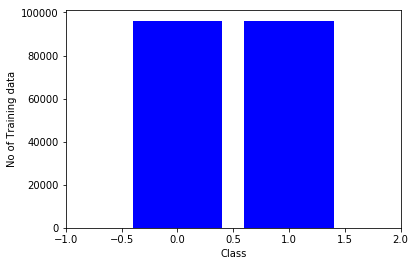

In [12]:
# Checking for class bias after data augmentation

unique_elements, counts_elements = np.unique(y_train_aug, return_counts = True)
print(np.asarray((unique_elements, counts_elements)))

plt.bar( np.arange( 2 ), counts_elements, align='center',color='blue' )
plt.xlabel('Class')
plt.ylabel('No of Training data')
plt.xlim([-1, 2])

plt.show()

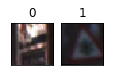

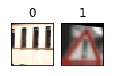

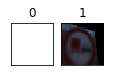

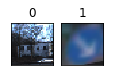

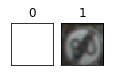

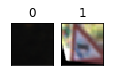

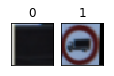

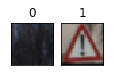

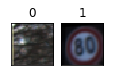

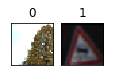

In [15]:
%matplotlib inline 

# Show examples from each class
class_names = np.unique(y_train_aug)
num_classes = len(class_names)

for r in range(90000,90010):
    fig = plt.figure(figsize=(8,8))
    for i in range(num_classes):
        ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
        ax.set_title(class_names[i])
        indices = np.where(np.isin(y_train_aug, class_names[i]))[0]
        plt.imshow(cv2.cvtColor(X_train_aug[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
    plt.show()

In [16]:
# Data pre-processing
new_split = 165000

tr_signs = np.array(X_train_aug)[0:new_split]
tr_labels = np.array(y_train_aug)[0:new_split]
va_signs = np.array(X_train_aug)[new_split:X_train_aug.shape[0]]
va_labels = np.array(y_train_aug)[new_split:X_train_aug.shape[0]]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

In [17]:
from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

Using TensorFlow backend.
/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [18]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

## Assignment 3.2: Convolutional Neural Network

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras import regularizers, optimizers
from keras.layers.normalization import BatchNormalization

cnn = Sequential()
## If You preprocessed with gray scaling and local histogram equivalization then input_shape = (32,32,1) else (32,32,3)
cnn.add(Conv2D(32, kernel_size=(3, 3),activation='relu', input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3)))
#cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(BatchNormalization())
cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))
cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))
#cnn.add(Flatten())
cnn.add(GlobalAveragePooling2D())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.7))
cnn.add(Dense(num_classes, activation='softmax'))

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxP

In [20]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

data = cnn.fit(
    tr_signs, tr_labels, 
    batch_size=128, epochs=100, verbose=2, 
    validation_data=(va_signs, va_labels), 
    callbacks=[tensorboard, early_stopping]
)

start = time()
loss, acc = cnn.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Instructions for updating:
Use tf.cast instead.
Train on 165000 samples, validate on 27348 samples
Epoch 1/100
 - 66s - loss: 0.0617 - acc: 0.9775 - val_loss: 0.0151 - val_acc: 0.9946
Epoch 2/100
 - 52s - loss: 0.0168 - acc: 0.9947 - val_loss: 0.0055 - val_acc: 0.9986
Epoch 3/100
 - 52s - loss: 0.0122 - acc: 0.9961 - val_loss: 0.0089 - val_acc: 0.9971
Epoch 4/100
 - 52s - loss: 0.0098 - acc: 0.9968 - val_loss: 0.0180 - val_acc: 0.9954
Epoch 5/100
 - 52s - loss: 0.0079 - acc: 0.9974 - val_loss: 0.0060 - val_acc: 0.9977
Epoch 6/100
 - 52s - loss: 0.0075 - acc: 0.9976 - val_loss: 0.0355 - val_acc: 0.9902
Epoch 7/100
 - 52s - loss: 0.0066 - acc: 0.9979 - val_loss: 0.0041 - val_acc: 0.9988
Epoch 8/100
 - 52s - loss: 0.0055 - acc: 0.9984 - val_loss: 0.0075 - val_acc: 0.9979
Epoch 9/100
 - 52s - loss: 0.0058 - acc: 0.9982 - val_loss: 0.0033 - val_acc: 0.9990
Epoch 10/100
 - 52s - loss: 0.0044 - acc: 0.9986 - val_loss: 0.0157 - val_acc: 0.9948
Epoch 11/100
 - 52s - loss: 0.0045 - acc: 0.9986 -

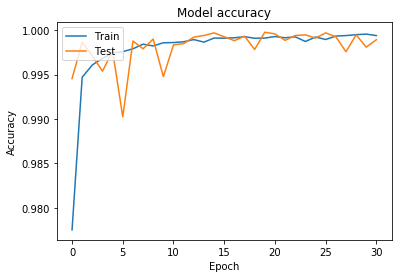

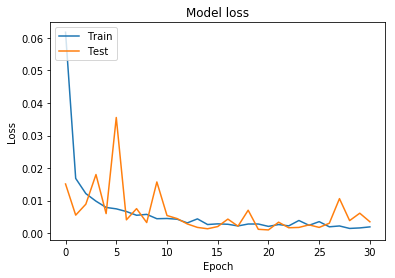

In [21]:
# Plot training & validation accuracy values
plt.plot(data.history['acc'])
plt.plot(data.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[50135    18]
 [    7   354]]


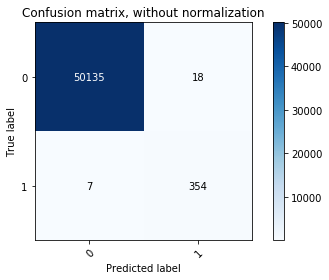

In [22]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(
    np.argmax(te_labels, axis=1), 
    np.argmax(cnn.predict(te_signs), axis=1), 
    classes=np.array([0,1]),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
# plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

plt.show()

In [23]:
import pickle
with open('./models/test_pred.pickle', 'rb') as fp:
    test_pred = pickle.load(fp)

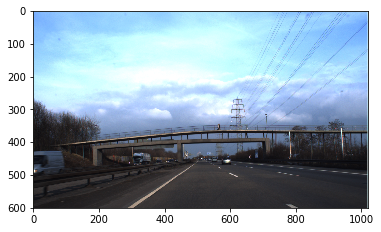

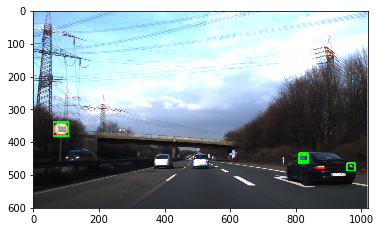

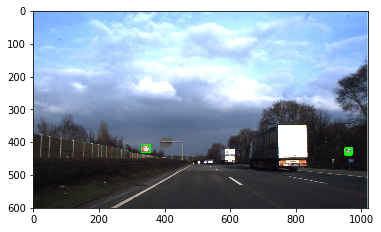

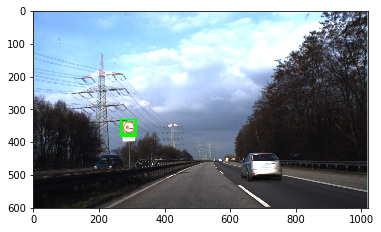

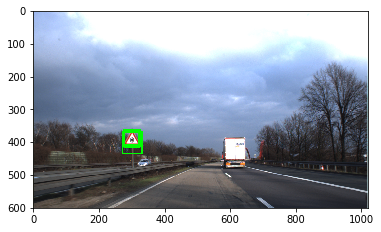

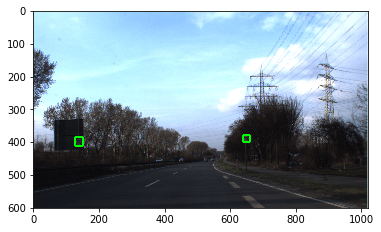

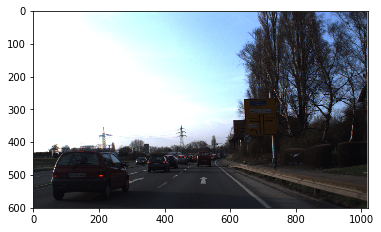

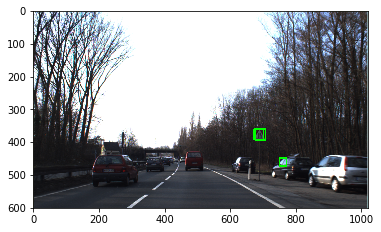

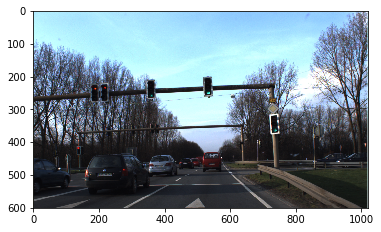

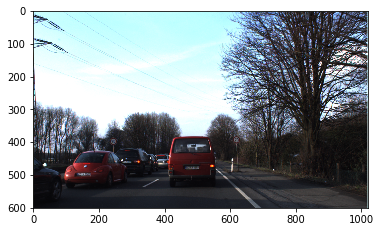

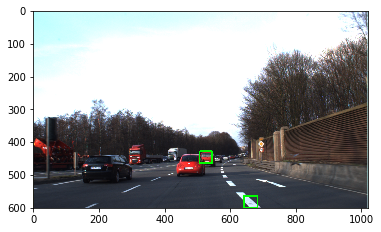

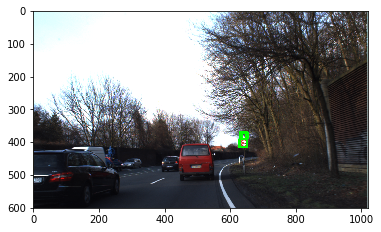

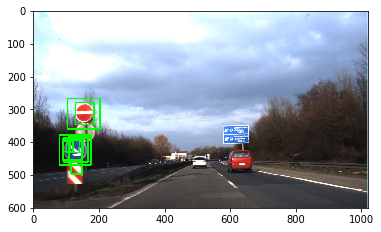

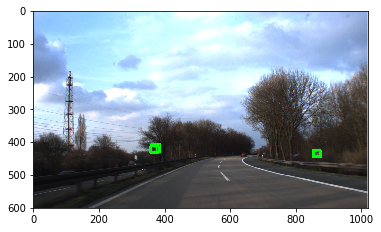

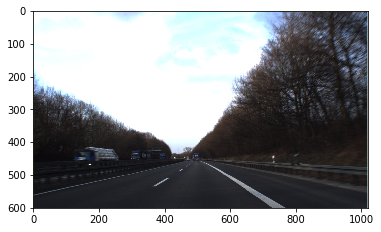

In [24]:
# run some tests
i=0

number_of_images = 15
number_of_boxes_to_draw = 1000

for filename in test_images:
    # Draw predictions
    aux = test_images.get(filename)[0].copy()
    for bbox in test_pred.get(filename)[0][:number_of_boxes_to_draw]:  
        
        #filter some boxes before making predictions
        dx = int(bbox[0])-int(bbox[2])
        dy = int(bbox[1])-int(bbox[3])
        ratio = abs(dy/dx)
        if ratio<1:
            ratio=1/ratio
        if ratio>1.2:
            continue
        
        # make a prediction
        roi = test_images.get(filename)[0][int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        SIGN_SIZE_CNN = (32, 32)
        roi_resized = cv2.resize(roi, SIGN_SIZE_CNN)
        roi_resized = roi_resized.astype('float32')
        roi_resized /= 255.0
        roi_resized = np.reshape(roi_resized, [1,SIGN_SIZE_CNN[0],SIGN_SIZE_CNN[1],3])
        
        confidence = cnn.predict(roi_resized)
        
        # print rectangle if confidence is large
        # those are boxes that we think have the largest probability to have a traffic sign inside
#         dx = int(bbox[0])-int(bbox[2])
#         dy = int(bbox[1])-int(bbox[3])
#         ratio = abs(dy/dx)
#         if ratio<1:
#             ratio=1/ratio
        if confidence[0][1] > 0.9:
            cv2.rectangle(aux, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), (0,255,0), 3)

        # print contents of box if you like
#         not_a_sign = aux[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
#         plt.imshow(cv2.cvtColor(not_a_sign, cv2.COLOR_BGR2RGB))
#         plt.show()
            

    
    # Draw ground truth
    # this is what we should detect
    if filename in test_files:
        for idx in [i for i, x in enumerate(test_files) if x == filename]:
            bbox = test_bboxes[idx]
#             cv2.rectangle(aux, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), (0,0,255), 3)
            
            # print contents of box if you like
#             sign = aux[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
#             plt.imshow(cv2.cvtColor(sign, cv2.COLOR_BGR2RGB))
#             plt.show()
    
    plt.imshow(cv2.cvtColor(aux, cv2.COLOR_BGR2RGB))
    plt.show()
    i+=1
    if i==number_of_images: break

In [25]:
# serialize model to JSON
model_json = cnn.to_json()
with open("./models/bin_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
cnn.save_weights("./models/bin_model.h5")
print("Saved model to disk")

Saved model to disk
